In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.colors as colors

In [2]:
metabolite='trehalose'

In [3]:
def MMETSP_groupby(df, level='Division', normalized=True):
    division_MMETSP = df.merge(mmetsp_taxonomy[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = mmetsp_taxonomy.groupby(level)['Notes'].count()
    if normalized:
        division_MMETSP = division_MMETSP.T/total_per_group
        division_MMETSP = division_MMETSP.T
    return(division_MMETSP, total_per_group)

def create_cluster_bar(grouped_MMETSP, total_per_group, size=[12,12],
                       cutoff=False, c=5, genome=False, dropzero=False):
    grouped_MMETSP=grouped_MMETSP.dropna()
    if cutoff: 
        ii=total_per_group>c
        grouped_MMETSP= grouped_MMETSP.loc[ii]
        total_per_group=total_per_group[ii]
    if dropzero:
        ss= grouped_MMETSP[grouped_MMETSP.sum(axis=1)>0].index
        print(ss)
        grouped_MMETSP = grouped_MMETSP.loc[ss]
        total_per_group=total_per_group[ss]
    cluster = sns.clustermap(grouped_MMETSP, cmap='binary', yticklabels=1)
    cluster.fig.set_size_inches(size)
    
    # make some space to the right in the figure
    cluster.gs.update(right=0.95)
    # divide existing axes
    divider = make_axes_locatable(cluster.ax_heatmap)
    divider2 = make_axes_locatable(cluster.ax_col_dendrogram)
    # create new axes for bar plot 
    ax = divider.append_axes("right", size="20%", pad=1.7)
    # create empty space of same size as bar plot axes (don't use this space)
    nax = divider2.new_horizontal(size="20%", pad=1.7)
    target = [t.get_text() for t in np.array(cluster.ax_heatmap.get_yticklabels())]
    ind= np.array([list(grouped_MMETSP.index.values).index(t) for t in target])
    # plot bar plot in ax
    ax.barh(np.arange(len(target)), total_per_group.values[ind], color='k')
    ax.set_yticklabels([])
    ax.set_ylim(-0.5,len(grouped_MMETSP.index)-.5)
    ax.invert_yaxis()
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    if genome:
        ax.set_xlabel('Total Genomes')
    else:
        ax.set_xlabel('Total Transcriptomes')
    ax.xaxis.set_label_position('top') 
    cluster.cax.set_position([0.1, .8, .02, 0.2])
    cluster.cax.set_ylabel('Proportion Gene present')

    plt.show()
    return(cluster)

def bact_groupby(df, level='phylum', normalized=True):
    division_bact = df.merge(MarRef[level], left_index=True, right_index=True).groupby(level).sum()
    total_per_group = MarRef.groupby(level)['alt_elev'].count()
    if normalized:
        division_bact = division_bact.T/total_per_group
        division_bact = division_bact.T
    return(division_bact, total_per_group)

def calculate_all_reactions(reactions, dataframe):
    outdf = pd.DataFrame()
    for i in dataframe.index:
        for func in reactions: 
            name, val = func(dataframe.loc[i])
            outdf.loc[i, name]=val
    return(outdf)

# Pathways




In [38]:
# Trehalose synthesis from g-6-p

def synthesis_g6p(organism):
    step1 = set(['K00697', 'K16055'])
    step2 = set(['K01087', 'K16055' ])
    kos = set(organism[organism==1].index)
    synthesis = 0
    if step1.intersection(kos):
        s1 = 1
    else:
        s1 = 0
    if step2.intersection(kos):
        s2 = 1
    else:
        s2 = 0
    if s1+s2 == 2: 
        synthesis = 1
    return('Trehalose synthesis from g-6-p', synthesis)

# Trehalose synthesis from glucose (not adding previous steps for synthesizing glucose because it seems like too much info?)
def synthesis_glucose(organism):
    kos = set(organism[organism==1].index)
    step1 = set(['K13057'])
    synthesis = 0
    if step1.intersection(kos):
        s1 = 1
    else:
        s1 = 0
    if s1 == 1: 
        synthesis =1
    return('Trehalose synthesis from glucose', synthesis)

# Trehalose synthesis from maltose 
def synthesis_maltose(organism):
    kos = set(organism[organism==1].index)  
    step1 = set(['K05343'])
    synthesis = 0
    if step1.intersection(kos):
        s1 = 1
    else:
        s1 = 0
    if s1 == 1: 
        synthesis = 1
    return('Trehalose synthesis from maltose', synthesis)

# Trehalose synthesis from starch
def synthesis_starch(organism):
    step1 = set(['K01214'])
    step2 = set(['K06044' ])
    step3 = set(['K01236'])
    kos = set(organism[organism==1].index)
    synthesis = 0
    if step1.intersection(kos):
        s1 = 1
    else:
        s1 = 0
    if step2.intersection(kos):
        s2 = 1
    else:
        s2 = 0
    if step3.intersection(kos):
        s3 = 1
    else:
        s3 = 0
    if s1+s2+s3 == 3: 
        synthesis = 1

    return('Trehalose synthesis from starch', synthesis)

#Trehalose catabolism
def catabolism(organism):
    step1 = set(['K01194','K22934','K05342','K02777','K02819 '])
    kos = set(organism[organism==1].index)
    synthesis = 0
    if step1.intersection(kos):
        s1 = 1
    else:
        s1 = 0
    if s1 == 1: 
        synthesis = 1
    return('Trehalose catabolism', synthesis)

# transporters = {'tauB':'K10831','tauA':'K15551','tauC':'K15552'}
reactions = [synthesis_g6p, synthesis_glucose, synthesis_maltose, synthesis_starch, catabolism]
#Glycine betaine synthesis (from glycine)



# READ IN DATA

In [29]:
df_bact = pd.read_csv('../kofamscan/ko_tables/'+metabolite+'_bact.csv', index_col=0)
df_bact.index = df_bact.index.str.split('/').str[3].str.strip('.csv')
df_mmetsp = pd.read_csv('../kofamscan/ko_tables/'+metabolite+'_mmetsp.csv', index_col=0)
df_mmetsp.index=df_mmetsp.index.str.split('/').str[3].str.strip('_clean.csv')
### Other

MarRef = pd.read_csv('../MarRef_DBs/MarRef_v5.txt', sep='\t', index_col=44)
df_mmetsp.index = df_mmetsp.index.str.strip('_clean')
mmetsp_taxonomy = pd.read_csv('/vortexfs1/omics/alexander/data/mmetsp/taxonomy_v2.txt', sep='\t',
                              encoding = "ISO-8859-1", index_col='Source_ID')

# Bacterial Genomes

Text(0, 0.5, 'Proportion abundance across MarRef')

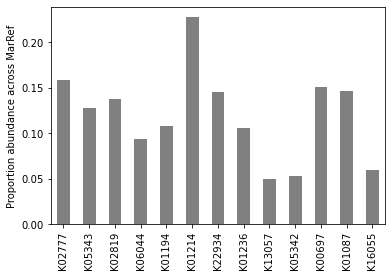

In [30]:
ax = (df_bact.sum()/len(df_bact)).plot(kind = 'bar', color='gray')
ax.set_ylabel('Proportion abundance across MarRef')


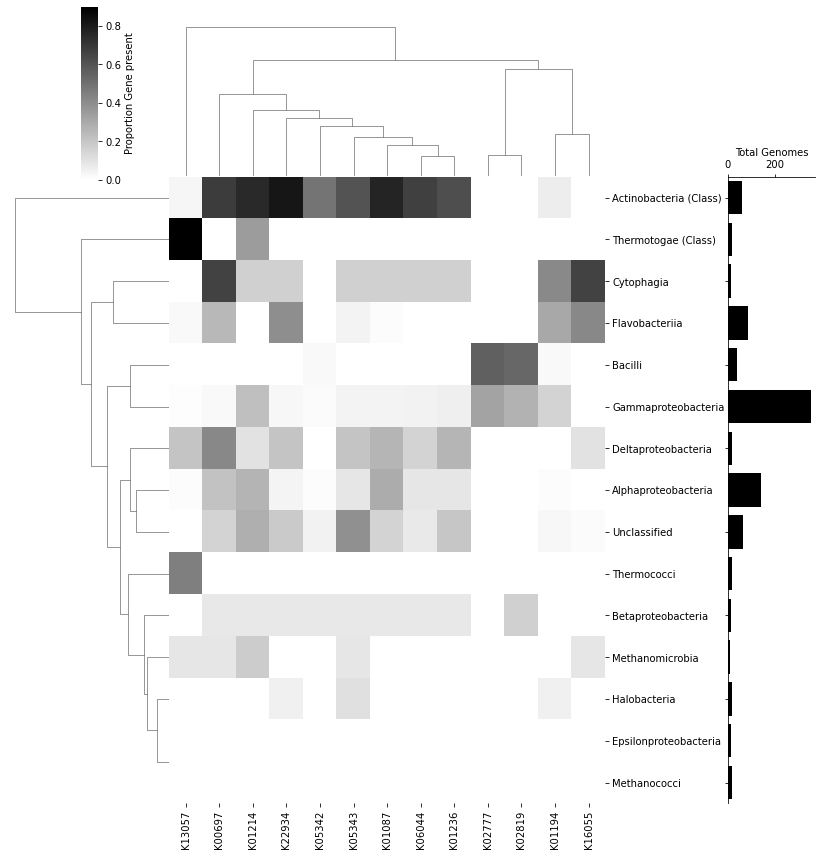

In [31]:
division_bact, total_bac_group =bact_groupby(df_bact, level='class')
create_cluster_bar(division_bact, total_bac_group, genome=True, cutoff=True, c=10)

## Reaction summary

In [32]:
reaction_bact_df = calculate_all_reactions(reactions, df_bact)
reaction_bact_df.sum()

Trehalose synthesis from g-6-p      145.0
Trehalose synthesis from glucose     45.0
Trehalose synthesis from maltose    115.0
Taurine synthesis from tauropine     79.0
Taurine catabolism                  357.0
dtype: float64

In [33]:
# transporters_bact_df = df_bact[transporters.values()]
# transporters_bact_df.rename({v: k for k, v in transporters.items()}, axis=1, inplace=True)

In [34]:
df_bact.columns

Index(['K02777', 'K05343', 'K02819', 'K06044', 'K01194', 'K01214', 'K22934',
       'K01236', 'K13057', 'K05342', 'K00697', 'K01087', 'K16055'],
      dtype='object')

Index(['Actinoalloteichus', 'Aeromonas', 'Aliivibrio', 'Altererythrobacter',
       'Alteromonas', 'Aquimarina', 'Archaeoglobus', 'Bacillus',
       'Celeribacter', 'Cellulophaga', 'Colwellia', 'Corynebacterium',
       'Desulfovibrio', 'Dokdonia', 'Edwardsiella', 'Erythrobacter',
       'Flavobacterium', 'Formosa', 'Francisella', 'Gramella', 'Maribacter',
       'Marinobacter', 'Methanosarcina', 'Micromonospora', 'Mycobacterium',
       'Nitrosococcus', 'Nonlabens', 'Paenibacillus', 'Photobacterium',
       'Planococcus', 'Polaribacter', 'Pseudoalteromonas', 'Pseudomonas',
       'Pyrococcus', 'Rhodobacter', 'Rhodococcus', 'Salinibacter',
       'Shewanella', 'Streptococcus', 'Streptomyces', 'Synechococcus',
       'Thermococcus', 'Thermosipho', 'Thermotoga', 'Unclassified', 'Vibrio',
       'Yersinia'],
      dtype='object', name='genus')


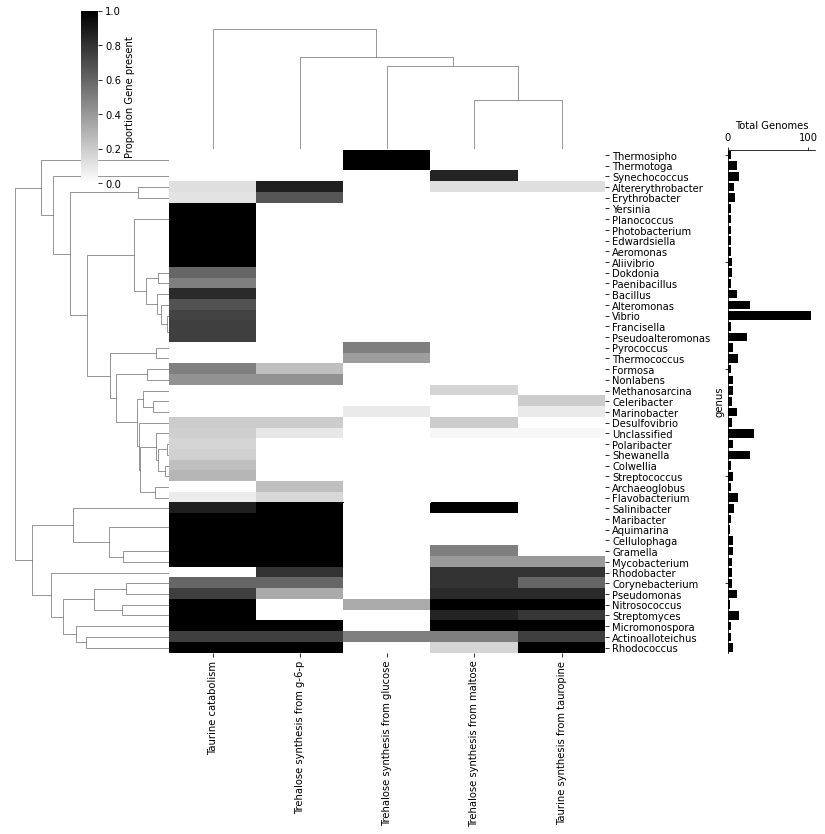

In [41]:
grouped_bact, total_bac_group  = bact_groupby(reaction_bact_df, level='genus', normalized=True)
create_cluster_bar(grouped_bact, total_bac_group, dropzero=True, genome=True, cutoff=True, c=2,)

In [21]:
# grouped_bact, total_bac_group  = bact_groupby(transporters_bact_df, level='class', normalized=True)
# create_cluster_bar(grouped_bact, total_bac_group, dropzero=True, genome=True, cutoff=True, c=2,)

# MMETSP 

Text(0, 0.5, 'Proportion abundance across MMETSP')

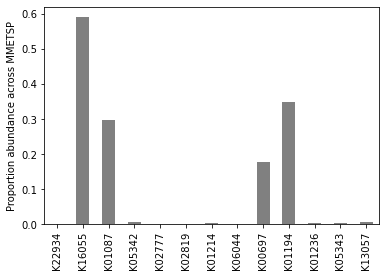

In [25]:
ax = (df_mmetsp.sum()/len(df_mmetsp)).plot(kind = 'bar', color='gray')
ax.set_ylabel('Proportion abundance across MMETSP')


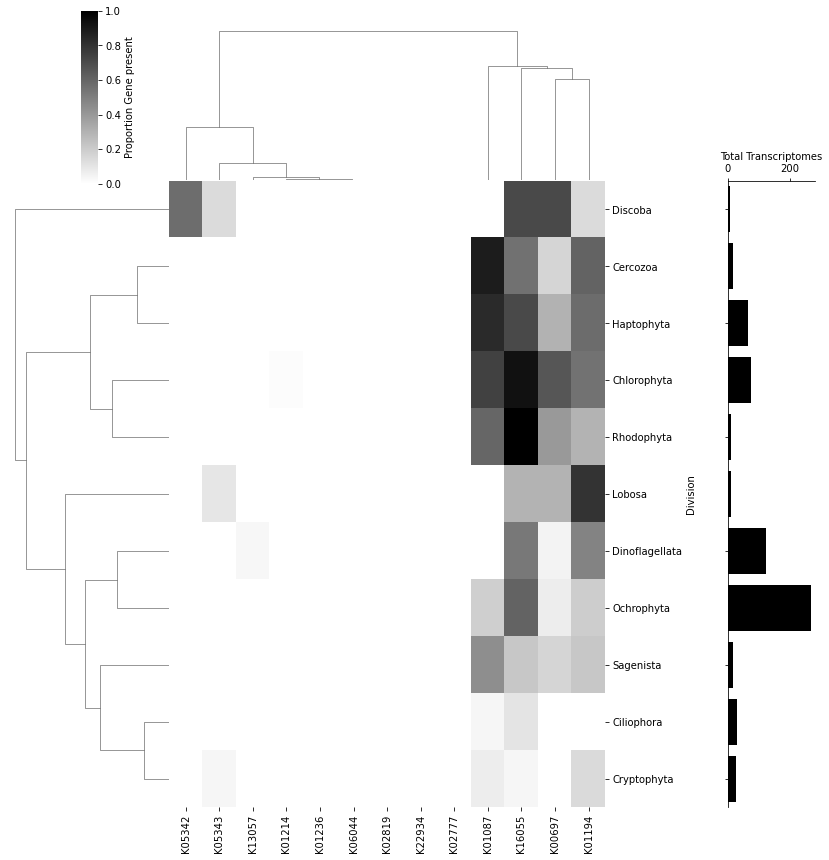

In [26]:
grouped_MMETSP, total_per_group  = MMETSP_groupby(df_mmetsp, 'Division', normalized=True)
create_cluster_bar(grouped_MMETSP, total_per_group,cutoff=True)


In [42]:
reaction_mmetsp_df = calculate_all_reactions(reactions, df_mmetsp)
reaction_mmetsp_df.sum()

Trehalose synthesis from g-6-p      394.0
Trehalose synthesis from glucose      5.0
Trehalose synthesis from maltose      3.0
Trehalose synthesis from starch       0.0
Trehalose catabolism                236.0
dtype: float64

In [28]:
# transporters_mmetsp_df = df_mmetsp[transporters.values()]
# transporters_mmetsp_df.rename({v: k for k, v in transporters.items()}, axis=1,inplace=True)

/vortexfs1/home/halexander/.conda/envs/general_plotting/lib/python3.6/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['Apicomplexa', 'Cercozoa', 'Chlorophyta', 'Ciliophora', 'Conosa',
       'Cryptophyta', 'Dinoflagellata', 'Discoba', 'Discosea', 'Foraminifera',
       'Fungi', 'Glaucophyta', 'Hacrobia_X', 'Haptophyta', 'Lobosa',
       'Ochrophyta', 'Opalozoa', 'Rhodophyta', 'Sagenista'],
      dtype='object', name='Division')


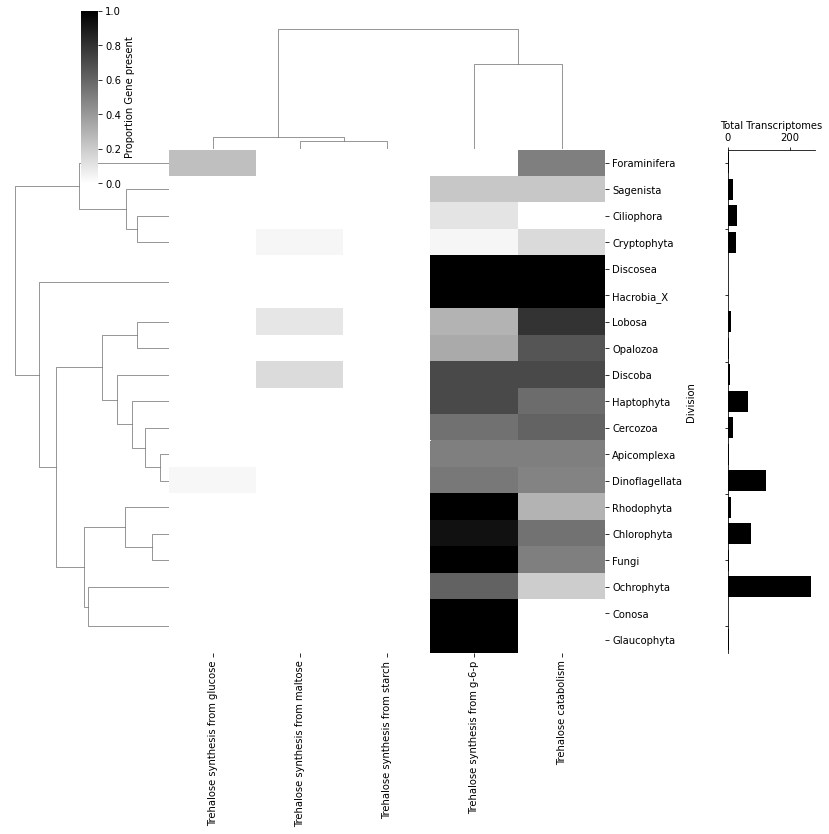

In [43]:
grouped_MMETSP, total_per_group  = MMETSP_groupby(reaction_mmetsp_df, 'Division', normalized=True)
create_cluster_bar(grouped_MMETSP, total_per_group, dropzero=True)

In [44]:
# grouped_MMETSP, total_per_group  = MMETSP_groupby(transporters_mmetsp_df, 'Genus', normalized=True)
# create_cluster_bar(grouped_MMETSP, total_per_group, dropzero=True)

Text(0.5, 1.0, 'trehalose')

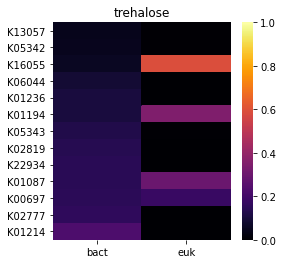

In [45]:
comp_df = pd.DataFrame()
comp_df['bact']=(df_bact.sum()/len(df_bact))
comp_df['euk']=(df_mmetsp.sum()/len(df_mmetsp))
comp_df = comp_df.sort_values(by='bact')
fig, ax = plt.subplots(1)
fig.set_size_inches(4,4)
sns.heatmap( data= comp_df, vmin=0., vmax=1., cmap='inferno')
ax.set_title(metabolite)